In [1]:
pip install torch

  Using cached torch-2.5.1-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.21.5-py3-none

In [2]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 9.0 MB/s eta 0:00:0000:0100:01m


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from PIL import Image
import zipfile
import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, GaussianBlur, RandomAffine, ToTensor, Normalize, RandomPerspective, RandomErasing
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 165MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/40]
Train Loss: 2.1971, Train Accuracy: 41.36%
Val Loss: 1.0052, Val Accuracy: 70.21%
Epoch [2/40]
Train Loss: 0.7567, Train Accuracy: 77.46%
Val Loss: 0.7192, Val Accuracy: 79.47%
Epoch [3/40]
Train Loss: 0.2796, Train Accuracy: 91.46%
Val Loss: 0.6169, Val Accuracy: 82.52%
Epoch [4/40]
Train Loss: 0.1009, Train Accuracy: 97.06%
Val Loss: 0.6371, Val Accuracy: 82.80%
Epoch [5/40]
Train Loss: 0.0565, Train Accuracy: 98.44%
Val Loss: 0.6646, Val Accuracy: 82.55%
Epoch [6/40]
Train Loss: 0.0386, Train Accuracy: 98.88%
Val Loss: 0.6562, Val Accuracy: 83.49%
Epoch [7/40]
Train Loss: 0.0377, Train Accuracy: 98.84%
Val Loss: 0.6812, Val Accuracy: 82.90%
Epoch [8/40]
Train Loss: 0.0143, Train Accuracy: 99.70%
Val Loss: 0.6156, Val Accuracy: 84.82%
Epoch [9/40]
Train Loss: 0.0098, Train Accuracy: 99.78%
Val Loss: 0.6167, Val Accuracy: 85.02%
Epoch [10/40]
Train Loss: 0.0067, Train Accuracy: 99.87%
Val Loss: 0.6190, Val Accuracy: 85.35%
Epoch [11/40]
Train Loss: 0.0054, Train Accuracy:

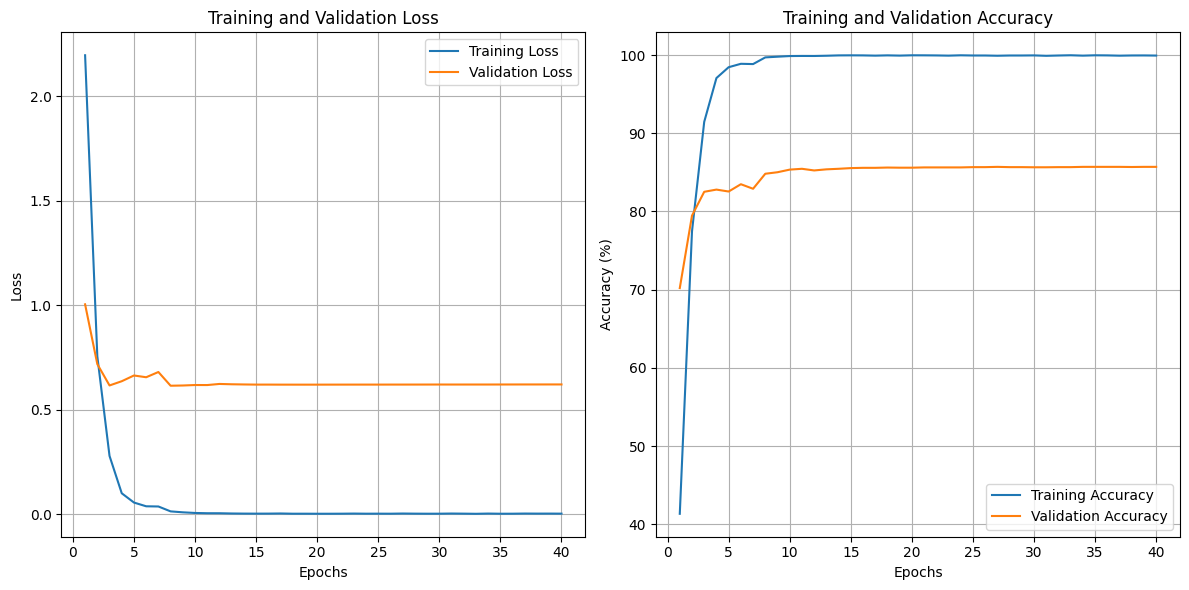

Final Test Accuracy: 85.70%


In [ ]:
transform_train = Compose([
    Resize((224, 224)),  # Resize images to a fixed size
    RandomHorizontalFlip(p=0.5),  # Flip images horizontally with a 50% chance
    RandomRotation(15),  # Rotate images randomly up to ±15 degrees
    ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Adjust brightness, contrast, etc.
    RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Apply affine transformations
    RandomPerspective(distortion_scale=0.5, p=0.5),  # Simulate perspective distortion
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Apply Gaussian blur
    RandomErasing(p=0.5),  # Randomly erase parts of the image
    ToTensor(),  # Convert image to PyTorch tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet standards
])

transform_test = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Dataset loading
zip_file_path = '/content/data4.zip'
assert os.path.exists(zip_file_path), "Zip file does not exist!"
extract_to = '/content'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

data_dir = '/content/data4'
dataset = datasets.ImageFolder(root=data_dir)
num_classes = len(dataset.classes)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataset.dataset.transform = transform_train
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model setup
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modify the classifier to suit the new task
model.classifier[5] = nn.Dropout(p=0.5)
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

# Unfreeze the last 8 layers in the feature extractor
for param in model.features[:-8].parameters():  # Freeze earlier layers
    param.requires_grad = False
for param in model.features[-8:].parameters():  # Unfreeze later layers
    param.requires_grad = True

# Move the model to the device
model = model.to(device)

# Define optimizer with separate parameter groups
optimizer = torch.optim.Adam([
    {'params': model.features[-8:].parameters(), 'lr': 1e-5},  # Fine-tuning layers with smaller LR
    {'params': model.classifier.parameters(), 'lr': 1e-4}  # Classifier with a larger LR
], weight_decay=1e-4)

# Loss function
criterion = nn.CrossEntropyLoss()

# scheduler for dynamic learning rate adjustment
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs= 40

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct=0
    train_total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs,1)
        train_total += labels.size(0)
        train_correct += (predicted==labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (predicted==labels).sum().item()

    val_loss /= len(test_loader.dataset)
    val_accuracy = 100*val_correct/ val_total
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    # Print epoch stats
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Update the scheduler
    scheduler.step(val_loss)

max_train_acc_epoch = train_accuracies.index(max(train_accuracies))+1
max_val_acc_epoch = val_accuracies.index(max(val_accuracies))+1

print(f"Maximum Training Accuracy: {max(train_accuracies):.2f}% at Epoch {max_train_acc_epoch}")
print(f"Best Validation Accuracy: {max(val_accuracies):.2f}% at Epoch {max_val_acc_epoch}")

# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Evaluate final accuracy on the test set
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Test Accuracy: {100 * correct / total:.2f}%')